In [1]:
import numpy as np
import pandas as pd
import re # For regular expressions

from scipy.spatial.distance import cosine as distance_calc
import matplotlib.pyplot as plt

# BeautifulSoup is used to remove html tags from the text
from bs4 import BeautifulSoup 

# Stopwords can be useful to undersand the semantics of the sentence.
# Therefore stopwords are not removed while creating the word2vec model.
# But they will be removed  while averaging feature vectors.
import nltk
from nltk.stem import WordNetLemmatizer
import sys
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from gensim.models import word2vec
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

**Data parsing**

In [2]:
dataset = pd.read_csv("200Reviews.csv") # Read the CSV

In [3]:
dataset

,Unnamed: 0,id,sentiment,review
0,0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."
...,...,...,...,...
195,195,"""8807_9""",1,"""This is a collection of documentaries that la..."
196,196,"""12148_10""",1,"""This movie has a lot of comedy, not dark and ..."
197,197,"""10771_2""",0,"""Have not watched kids films for some years, s..."
198,198,"""6766_3""",0,"""You probably heard this phrase when it come t..."


**Preprocessing**

In [4]:
def review_sentences(review, tokenizer, remove_stopwords=False):
    raw_sentences = tokenizer.tokenize(review.strip())     # 1. Using nltk tokenizer
    sentences = []
    for raw_sentence in raw_sentences:                     # 2. Loop for each sentence
        if len(raw_sentence)>0:
            sentences.append(review_wordlist(raw_sentence,remove_stopwords))                 
    return sentences                                       # This returns the list of lists

In [5]:
def review_wordlist(review, remove_stopwords=False):
    review_text = BeautifulSoup(review).get_text()       # 1. Removing html tags
    review_text = re.sub("[^a-zA-Z]"," ",review_text)    # 2. Removing non-letter.
    words = review_text.lower().split()                  # 3. Converting to lower case and splitting
    if remove_stopwords:                                 # 4. Optionally remove stopwords
        stops = set(stopwords.words("english"))     
        words = [w for w in words if not w in stops]
    
    return(words)

In [6]:
reviews = dataset['review'].tolist()  # Make the dataframe into list

In [7]:
sentences = []

In [8]:
# nltk.download('stopwords')

In [9]:
# Make a list of list of words
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
for review in reviews:
    sentences += review_sentences(review, tokenizer, remove_stopwords=True)

In [10]:
# Get all the unique words
word_list = []
for sentence in sentences:
    for word in sentence:
        word_list.append(word)
word_list = list(set(word_list))

In [11]:
len(word_list)

7004

**Co-occurence matrix**

In [12]:
# Set up the matrix
coocurrence_matrix = np.zeros((len(word_list), len(word_list)),np.float64)

In [13]:
# Fill the matrix
def process_sentence(sentence, window):
    list_of_indeces = [word_list.index(word) for word in sentence]
    for i,index1 in enumerate(list_of_indeces):
        start = i-window if i-window >=0 else 0
        end = i+window+1 if i+window+1 <=len(list_of_indeces) else len(list_of_indeces)
        for index2 in list_of_indeces[start:end]:
            if index1 != index2:
                coocurrence_matrix[index1,index2] +=1

In [14]:
# Fill the matrix
for sentence in sentences:
    process_sentence(sentence, 5)

In [15]:
# Show in dataframe
dataframe_cooc = pd.DataFrame(coocurrence_matrix)
dataframe_cooc.columns = word_list
dataframe_cooc.index = word_list
dataframe_cooc

,realisation,occurring,protracted,hyped,dull,lusty,timbre,awkward,escaping,worry,...,reminiscent,companionship,watched,distributors,united,admitted,qualify,heck,ramrodder,discovered
realisation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
occurring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
protracted,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hyped,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dull,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
admitted,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
qualify,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
heck,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ramrodder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Create the SVD**

In [16]:
la = np.linalg
U, S, V = la.svd(coocurrence_matrix, full_matrices=False)

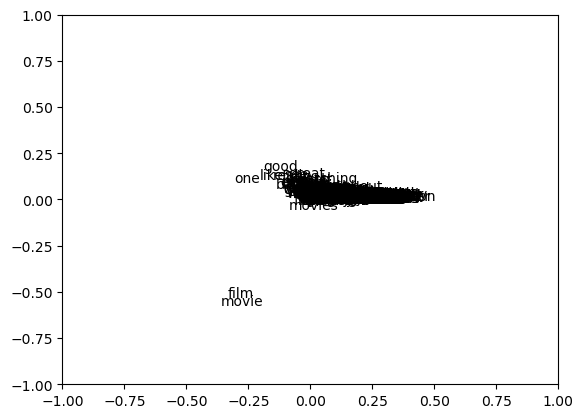

In [17]:
# Plot SVD
plt.ylim(-1,1)
plt.xlim(-1,1)

for i in iter(range(len(word_list))):
    plt.text(U[i,0],U[i,1],word_list[i])
plt.show()

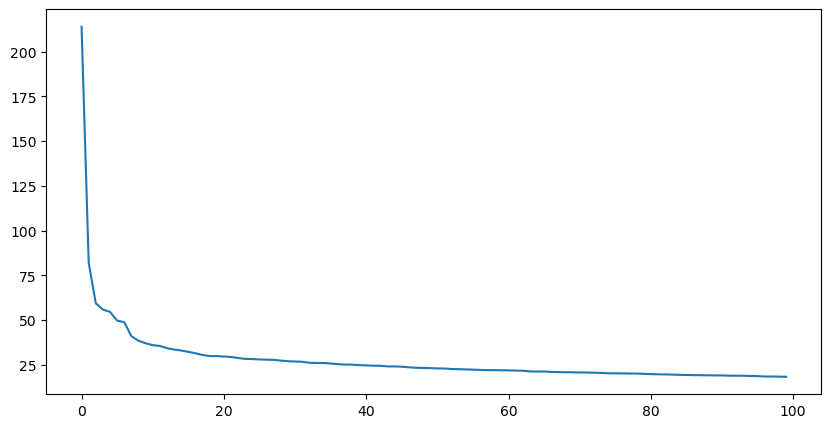

In [18]:
# Look at the first 100 eigenvalues
plt.figure(figsize = (10,5))
plt.plot(S[:100])
plt.show()

In [19]:
U.shape

(7004, 7004)

In [20]:
emb = U[:,:100]
emb.shape

(7004, 100)

In [21]:
print(emb)

[[-7.29087311e-04 -1.34912784e-03  7.00208260e-05 ... -3.90930221e-03
  -1.23227172e-03  1.81423218e-04]
 [-2.06613923e-03 -1.78232846e-03  9.74099237e-03 ... -1.90483716e-03
   4.55206577e-03 -1.37361751e-03]
 [-7.83500227e-04 -8.45390690e-04 -2.15944717e-04 ...  2.87103015e-04
   5.72561481e-03 -8.32381346e-03]
 ...
 [-2.29200386e-03 -2.79954765e-03 -2.80861333e-03 ... -1.51152871e-02
   3.70359255e-03 -9.32318433e-04]
 [-1.44090511e-03 -1.96560704e-03 -1.23781110e-03 ... -1.18439607e-04
   1.43134444e-02 -3.39172647e-03]
 [-1.05998650e-03 -1.89389324e-03  2.58465266e-05 ...  7.12874473e-03
   1.11607134e-03  1.00901423e-02]]


**SVD function**

In [22]:
def get_distance(word_1, word_2):
    return distance_calc(emb[word_list.index(word_1)], emb[word_list.index(word_2)])

def get_similarity(word_1, word_2):
    return cosine_similarity(emb[word_list.index(word_1),:].reshape(1,-1), emb[word_list.index(word_2),:].reshape(1,-1))[0][0]

In [23]:
def get_top_relevant_word_via_similarity(word_to_check, top_n=10):
    sorted_list = sorted(word_list,reverse=True, key=lambda word:get_similarity(word_to_check, word))
    sorted_pair = []
    for word in sorted_list[:top_n]:
        sorted_pair.append((word,get_similarity(word_to_check, word)))
    return sorted_pair

In [24]:
def get_top_relevant_word_via_distance(word_to_check, top_n=10):
    sorted_list = sorted(word_list, key=lambda word:get_distance(word_to_check, word))
    sorted_pair = []
    for word in sorted_list[:top_n]:
        sorted_pair.append((word,get_distance(word_to_check, word)))
    return sorted_pair

**Word2Vec**

In [25]:
# Creating the model and setting values for the various parameters
num_features = 100  # Word vector dimensionality
min_word_count = 3 # Minimum word count
num_workers = 4     # Number of parallel threads
context = 5        # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

# Initializing the train model
print("Training model....")
model = word2vec.Word2Vec(sentences,workers=num_workers,vector_size=num_features,min_count=min_word_count,window=context, sample=downsampling)

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "word2vec_model_100size_3mincount_5window"
model.save(model_name)
print("model saved")

Training model....
model saved


In [26]:
model = word2vec.Word2Vec.load("word2vec_model_100size_3mincount_5window")

**Comparison**

In [27]:
print("Word2Vec result")
model.wv.most_similar("movie")

Word2Vec result


[('film', 0.9883880615234375),
 ('one', 0.9877600073814392),
 ('like', 0.984801709651947),
 ('much', 0.9818921089172363),
 ('get', 0.9812399744987488),
 ('good', 0.9812301993370056),
 ('would', 0.9803956747055054),
 ('story', 0.9799787998199463),
 ('great', 0.9798790812492371),
 ('people', 0.9798113703727722)]

In [28]:
print("SVD result via similarity")
get_top_relevant_word_via_similarity("movie")
#The first one will be the word itself 

SVD result via similarity


[('movie', 0.9999999999999997),
 ('pounds', 0.20254861386707435),
 ('viles', 0.15259483759685644),
 ('matched', 0.14509388637772924),
 ('strike', 0.1376961719338061),
 ('splendor', 0.13039616119340322),
 ('russia', 0.13032776316380054),
 ('holocaust', 0.12640770232893644),
 ('preventing', 0.12640770232893642),
 ('nuclear', 0.1264077023289364)]

In [29]:
# Word2Vec similarity
model.wv.similarity('movie', 'film')

0.98838806

In [30]:
# SVD similarity
get_similarity('movie', 'film')

-0.00015416899115152163

**Discussion**

We can say that Word2Vec performs better compared to SVD

Additional: The result difference between cosine similarity and cosine distance is probably caused by the magnitude of matrix multiplication that cause floating point error.But regardless, they perform poorly compared to Word2Vec